In [13]:
# --- Cell 1: Setup & API Keys ---

import pandas as pd
import numpy as np
import os
import timeit
import matplotlib.pyplot as plt
import google.generativeai as genai
import time
from pathlib import Path
from dotenv import load_dotenv

# Pinecone imports
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec

# Load environment variables from .env file in the project directory
env_path = Path(__file__).parent / ".env" if "__file__" in globals() else Path(".env")

if env_path.exists():
    load_dotenv(env_path)
    print(f"✓ Loaded .env from {env_path}")
else:
    load_dotenv()
    print("✓ Called load_dotenv() to search for .env file in current/parent directories.")

# Get API keys from environment
GOOGLE_API_KEY = os.environ.get("GEMINI_API_KEY")
PINECONE_API_KEY = os.environ.get("PINECONE_API_KEY")

if GOOGLE_API_KEY:
    print("✓ Loaded 'GEMINI_API_KEY' from environment variables.")
else:
    print("✗ 'GEMINI_API_KEY' not found in environment.")
    
if PINECONE_API_KEY:
    print("✓ Loaded 'PINECONE_API_KEY' from environment variables.")
else:
    print("✗ 'PINECONE_API_KEY' not found in environment.")

# Google Gemini API Setup
try:
    if not GOOGLE_API_KEY:
        raise ValueError("GEMINI_API_KEY is not set.")
    genai.configure(api_key=GOOGLE_API_KEY)
    print("✓ Google Gemini client configured successfully.")
except Exception as e:
    print(f"✗ Error initializing Google Gemini client: {e}")

# Pinecone API Setup
pinecone_client = None
try:
    if not PINECONE_API_KEY:
        raise ValueError("PINECONE_API_KEY is not set.")
        
    pinecone_client = Pinecone(api_key=PINECONE_API_KEY)
    print("✓ Pinecone gRPC client initialized successfully.")
    print(f"Available Pinecone indexes: {pinecone_client.list_indexes()}")
except Exception as e:
    print(f"✗ Error initializing Pinecone client: {e}")


✓ Loaded .env from .env
✓ Loaded 'GEMINI_API_KEY' from environment variables.
✓ Loaded 'PINECONE_API_KEY' from environment variables.
✓ Google Gemini client configured successfully.
✓ Pinecone gRPC client initialized successfully.
Available Pinecone indexes: [{
    "name": "vibe-matcher-gemini-cosine",
    "metric": "cosine",
    "host": "vibe-matcher-gemini-cosine-mdv3d83.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 768,
    "deletion_protection": "disabled",
    "tags": null
}]
Available Pinecone indexes: [{
    "name": "vibe-matcher-gemini-cosine",
    "metric": "cosine",
    "host": "vibe-matcher-gemini-cosine-mdv3d83.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },

In [14]:
# --- Cell 2: Define Product Data ---

import pandas as pd

data = {
    "name": [
        "Boho Maxi Dress", "Streetwear Graphic Hoodie", "Tailored Linen Suit",
        "Cozy Cable-Knit Sweater", "Performance Active Leggings", "Vintage Trucker Jacket",
        "Mulberry Silk Pajama Set", "Techwear Cargo Pants", "Minimalist Court Sneaker",
        "Preppy Argyle Vest", "Gothic Lace Blouse", "Utility Field Jacket",
        "Sequin Party Dress", "Y2K Velour Tracksuit", "Coastal-Chic Cardigan"
    ],
    "desc": [
        "A flowy, ankle-length maxi dress featuring intricate paisley floral patterns, earthy tones of terracotta and olive, and delicate tassel ties. Perfect for music festivals, beach vacations, or a relaxed, artistic summer day.",
        
        "An oversized, heavy-weight cotton hoodie in jet black. Features a drop-shoulder cut and kangaroo pocket. This piece is the pinnacle of the energetic urban chic aesthetic, perfect for a modern, edgy, and high-fashion streetwear look.",
        
        "A meticulously tailored, single-breasted linen suit in a light sand beige. The breathable fabric keeps you cool and sharp, while the structured shoulders provide a modern silhouette. Designed for sophisticated summer weddings, coastal events, or elegant garden parties.",
        
        "A wonderfully chunky, oversized cable-knit turtleneck sweater made from a soft merino wool blend in a warm cream color. The ribbed cuffs and hem lock in warmth. Perfect for a cozy night in by the fire, reading a good book, or a crisp autumn walk.",
        
        "Seamless, high-waisted performance leggings in a bold sapphire blue. The four-way stretch and moisture-wicking fabric supports you during high-intensity workouts, yoga sessions, or long-distance running. Features a hidden waistband pocket for your key.",
        
        "A classic, 1990s-inspired trucker jacket in a medium-wash blue denim. Features authentic, slight distressing on the collar and cuffs, button-flap chest pockets, and a relaxed fit. A timeless, versatile piece for a casual, retro, or layered vibe.",
        
        "A luxurious, 100% mulberry silk pajama set in a deep emerald green with contrasting white piping. The button-down top and drawstring pants feel incredibly smooth and cool against the skin for a truly relaxing and indulgent evening.",
        
        "Water-resistant, multi-pocket cargo pants in a matte black technical fabric. A futuristic, functional silhouette. Built for navigating the city, this is a key piece for an energetic and chic urban wardrobe. Blends utility with a cyber-punk edge.",
        
        "A clean, low-top court sneaker crafted from premium white Italian leather. Features a simple, unbranded profile, gold-leaf lettering on the heel, and a comfortable recycled rubber sole. The perfect versatile shoe for a smart-casual or minimalist wardrobe.",
        
        "A sleeveless, v-neck sweater vest in a classic navy blue and green argyle pattern. Made from a soft cotton-cashmere blend. Ideal for layering over a button-down for a preppy, academic, or 'dark academia' aesthetic.",
        
        "An elegant, Victorian-inspired blouse in black sheer lace. Features a high ruffled neck, puffed shoulders, velvet ribbon details, and intricate floral detailing. Perfect for a gothic, romantic, or sophisticated evening ensemble.",
        
        "A rugged, military-inspired field jacket in olive drab cotton twill. Features four large front snap-pockets, a concealed hood in the collar, and an adjustable internal drawstring waist. A durable and practical piece for an outdoor, gorpcore, or utilitarian vibe.",
        
        "A dazzling, silver sequin mini dress with a plunging v-neck and structured long sleeves. This bodycon dress is fully lined for comfort and designed to catch the light. The ultimate statement piece for a birthday party, New Year's Eve, or a glamorous night out.",
        
        "A plush, baby pink velour tracksuit set. The zip-up hoodie and matching flared pants (with a low-rise fit) bring back early 2000s nostalgia. Incredibly soft and comfortable for lounging or making a bold, retro fashion statement.",
        
        "A long, open-front cardigan in a heavy-gauge beige cotton knit. Features a relaxed, slouchy fit, deep side pockets, and a shawl collar. Effortlessly chic and perfect for a breezy walk on the beach or curling up with tea. Embodies a quiet, coastal luxury."
    ],
    "tags": [
        ["boho", "festival", "summer", "maxi", "flowy", "earthy", "artistic", "paisley"],
        ["urban", "streetwear", "edgy", "energetic", "hoodie", "chic", "high-fashion"],
        ["formal", "summer", "elegant", "sophisticated", "wedding", "linen", "tailored", "coastal"],
        ["cozy", "comfortable", "winter", "autumn", "knitwear", "turtleneck", "oversized", "hygge"],
        ["active", "sporty", "energetic", "workout", "yoga", "running", "performance", "athleisure"],
        ["vintage", "casual", "retro", "denim", "jacket", "90s", "timeless", "layering"],
        ["luxury", "cozy", "relax", "pajamas", "silk", "elegant", "loungewear", "indulgent"],
        ["techwear", "urban", "futuristic", "functional", "streetwear", "cyberpunk", "energetic", "chic"],
        ["minimalist", "casual", "smart-casual", "sneaker", "versatile", "timeless", "leather", "clean"],
        ["preppy", "academic", "darkacademia", "layering", "vest", "classic", "argyle", "scholarly"],
        ["gothic", "victorian", "lace", "romantic", "elegant", "eveningwear", "sheer", "dark"],
        ["utilitarian", "military", "rugged", "outdoor", "gorpcore", "jacket", "practical", "workwear"],
        ["party", "glamorous", "sequin", "nye", "statement", "eveningwear", "bold", "clubbing"],
        ["y2k", "retro", "2000s", "loungewear", "comfortable", "nostalgic", "velour", "pink"],
        ["coastal", "minimalist", "luxury", "relaxed", "chic", "comfortable", "cardigan", "beach"]
    ]
}

df_products = pd.DataFrame(data)
print(f"--- Product DataFrame Created ({len(df_products)} items) ---")
print(df_products.head(5))

--- Product DataFrame Created (15 items) ---
                          name  \
0              Boho Maxi Dress   
1    Streetwear Graphic Hoodie   
2          Tailored Linen Suit   
3      Cozy Cable-Knit Sweater   
4  Performance Active Leggings   

                                                desc  \
0  A flowy, ankle-length maxi dress featuring int...   
1  An oversized, heavy-weight cotton hoodie in je...   
2  A meticulously tailored, single-breasted linen...   
3  A wonderfully chunky, oversized cable-knit tur...   
4  Seamless, high-waisted performance leggings in...   

                                                tags  
0  [boho, festival, summer, maxi, flowy, earthy, ...  
1  [urban, streetwear, edgy, energetic, hoodie, c...  
2  [formal, summer, elegant, sophisticated, weddi...  
3  [cozy, comfortable, winter, autumn, knitwear, ...  
4  [active, sporty, energetic, workout, yoga, run...  


In [15]:
# --- Cell 3: Create Embedding Functions ---

import numpy as np

EMBEDDING_MODEL = "models/text-embedding-004"
EMBEDDING_DIMENSION = 768

def get_gemini_embedding(text, task_type, title=None):
    """Generates an embedding for the given text using the Gemini API."""
    if not text:
        return None
    try:
        embed_args = {
            "model": EMBEDDING_MODEL,
            "content": text,
            "task_type": task_type
        }
        if task_type == "RETRIEVAL_DOCUMENT" and title:
            embed_args["title"] = title
            
        result = genai.embed_content(**embed_args)
        return result['embedding']
    except Exception as e:
        print(f"Error getting embedding (title: {title}): '{text[:50]}...': {e}")
        return None

def normalize_vector(v):
    """Normalizes a vector to have a length (L2 norm) of 1."""
    if v is None:
        return None
    v_array = np.array(v)
    norm = np.linalg.norm(v_array)
    if norm == 0:
        return v
    normalized = v_array / norm
    return normalized.tolist()

# Test the functions
test_raw_emb = get_gemini_embedding("This is a test", "RETRIEVAL_DOCUMENT", title="Test")
if test_raw_emb:
    print(f"Successfully generated raw embedding with {len(test_raw_emb)} dimensions.")
    test_norm_emb = normalize_vector(test_raw_emb)
    print(f"Normalized vector L2 norm: {np.linalg.norm(test_norm_emb):.2f}")
else:
    print("Failed to generate test embedding. Check API key and configuration.")

Successfully generated raw embedding with 768 dimensions.
Normalized vector L2 norm: 1.00


In [16]:
# --- Cell 4: Create & Populate Pinecone Index ---

INDEX_NAME = "vibe-matcher-gemini-cosine"

# Delete and recreate the index
if INDEX_NAME in [index.name for index in pinecone_client.list_indexes()]:
    print(f"Deleting existing index: {INDEX_NAME}...")
    pinecone_client.delete_index(INDEX_NAME)
    print(f"Index '{INDEX_NAME}' deleted.")
    time.sleep(2)

# Create the index
print(f"Creating new index: {INDEX_NAME}...")
start_index_create = time.time()
pinecone_client.create_index(
    name=INDEX_NAME,
    dimension=EMBEDDING_DIMENSION,
    metric="cosine", 
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

# Wait for index to be ready
print("Waiting for index to be ready...")
while not pinecone_client.describe_index(INDEX_NAME).status['ready']:
    time.sleep(3)
index_create_duration = time.time() - start_index_create
print(f"Index ready in {index_create_duration:.1f}s")

# Connect to the index
index = pinecone_client.Index(INDEX_NAME)
print(f"Connected to index. Stats: {index.describe_index_stats()}")

# Generate embeddings with progress tracking
print("\n--- Generating Embeddings ---")
start_embedding_time = time.time()

vectors_to_upsert = []
completed = 0
total = len(df_products)

print(f"Progress: 0/{total}", end='', flush=True)

for i, row in df_products.iterrows():
    # Combine name, description, and tags for richer embeddings
    tag_string = ", ".join(row['tags'])
    text_to_embed = f"Product: {row['name']}. Description: {row['desc']}. Vibes: {tag_string}."
    
    raw_embedding = get_gemini_embedding(
        text=text_to_embed,
        task_type="RETRIEVAL_DOCUMENT",
        title=row['name']
    )
    
    if raw_embedding:
        normalized_embedding = normalize_vector(raw_embedding)
        vectors_to_upsert.append({
            "id": str(i),
            "values": normalized_embedding,
            "metadata": {"product_name": row['name'], "desc": row['desc']}
        })
        completed += 1
        print(f"\rProgress: {completed}/{total} - ✓ {row['name'][:30]}", end='', flush=True)
    else:
        completed += 1
        print(f"\rProgress: {completed}/{total} - ✗ FAILED: {row['name'][:30]}", end='', flush=True)

print()
embedding_duration = time.time() - start_embedding_time
print(f"Embedding generation complete in {embedding_duration:.1f}s (avg: {embedding_duration/len(df_products):.2f}s per item)")

# Upsert the vectors
if vectors_to_upsert:
    print(f"\n--- Upserting {len(vectors_to_upsert)} vectors to Pinecone ---")
    index.upsert(vectors=vectors_to_upsert)
    print("Upsert complete.")
    print(f"Index stats after upsert: {index.describe_index_stats()}")

Deleting existing index: vibe-matcher-gemini-cosine...
Index 'vibe-matcher-gemini-cosine' deleted.
Index 'vibe-matcher-gemini-cosine' deleted.
Creating new index: vibe-matcher-gemini-cosine...
Creating new index: vibe-matcher-gemini-cosine...
Waiting for index to be ready...
Waiting for index to be ready...
Index ready in 26.1s
Index ready in 26.1s
Connected to index. Stats: {'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 0}},
 'total_vector_count': 0}

--- Generating Embeddings ---
Progress: 0/15Connected to index. Stats: {'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 0}},
 'total_vector_count': 0}

--- Generating Embeddings ---
Progress: 15/15 - ✓ Coastal-Chic Cardiganerngs
Embedding generation complete in 9.2s (avg: 0.62s per item)

--- Upserting 15 vectors to Pinecone ---

Embedding generation complete in 9.2s (avg: 0.62s per item)

--- Upserting 15 vectors to Pinecone ---
Upsert complete.
Upsert complete.
Index stats

In [17]:
# --- Cell 5: Create Search Function ---

def find_vibe_matches_pinecone(query, index, top_n=3, no_match_threshold=0.7):
    """
    Finds the top_n most similar products using a Pinecone index
    and the Gemini embedding model with COSINE similarity.
    """
    # Get the query embedding
    raw_query_embedding = get_gemini_embedding(query, task_type="RETRIEVAL_QUERY")
    
    if raw_query_embedding is None:
        return "Error: Could not embed query."

    # Normalize the query embedding before search
    normalized_query_embedding = normalize_vector(raw_query_embedding)

    # Query Pinecone
    query_response = index.query(
        vector=normalized_query_embedding,
        top_k=top_n,
        include_metadata=True 
    )
    
    # Process the results
    matches = query_response['matches']
    
    # Handle edge case: No good match
    if not matches or matches[0]['score'] < no_match_threshold:
        fallback_message = "No strong vibe match found. Try rephrasing your vibe!"
        if matches:
             fallback_message = (
                f"No strong vibe match found (top score: {matches[0]['score']:.4f}). "
                "Try rephrasing your vibe!"
             )
        return fallback_message

    # Format results into a DataFrame
    results_list = []
    for match in matches:
        results_list.append({
            "name": match['metadata']['product_name'],
            "desc": match['metadata']['desc'],
            "similarity_score": match['score']
        })
    
    return pd.DataFrame(results_list)

--- 🧪 Starting Vibe Matcher Test & Evaluation ---
Testing vibe queries and evaluating results.

🔍 Match Quality Criteria:
  - 🔥 Strong Match: Score >= 0.7
  - 👍 Good Match:   Score >= 0.55 and < 0.7
  - ❌ No Match:     Score < 0.55
--------------------------------------------------

--- Test Query 1: 'energetic urban chic' ---
  📊 Match Score: 0.6386
  👍 Match Quality: Good Match
  ⏱️ Search Speed: 2048 ms (2.05 seconds)

  Top Results Found:
    1. Streetwear Graphic Hoodie (Score: 0.6386)
       An oversized, heavy-weight cotton hoodie in jet black. Features a drop-shoulder cut and kangaroo poc...
    2. Techwear Cargo Pants (Score: 0.5984)
       Water-resistant, multi-pocket cargo pants in a matte black technical fabric. A futuristic, functiona...
    3. Coastal-Chic Cardigan (Score: 0.5418)
       A long, open-front cardigan in a heavy-gauge beige cotton knit. Features a relaxed, slouchy fit, dee...
--------------------------------------------------

--- Test Query 2: 'something c

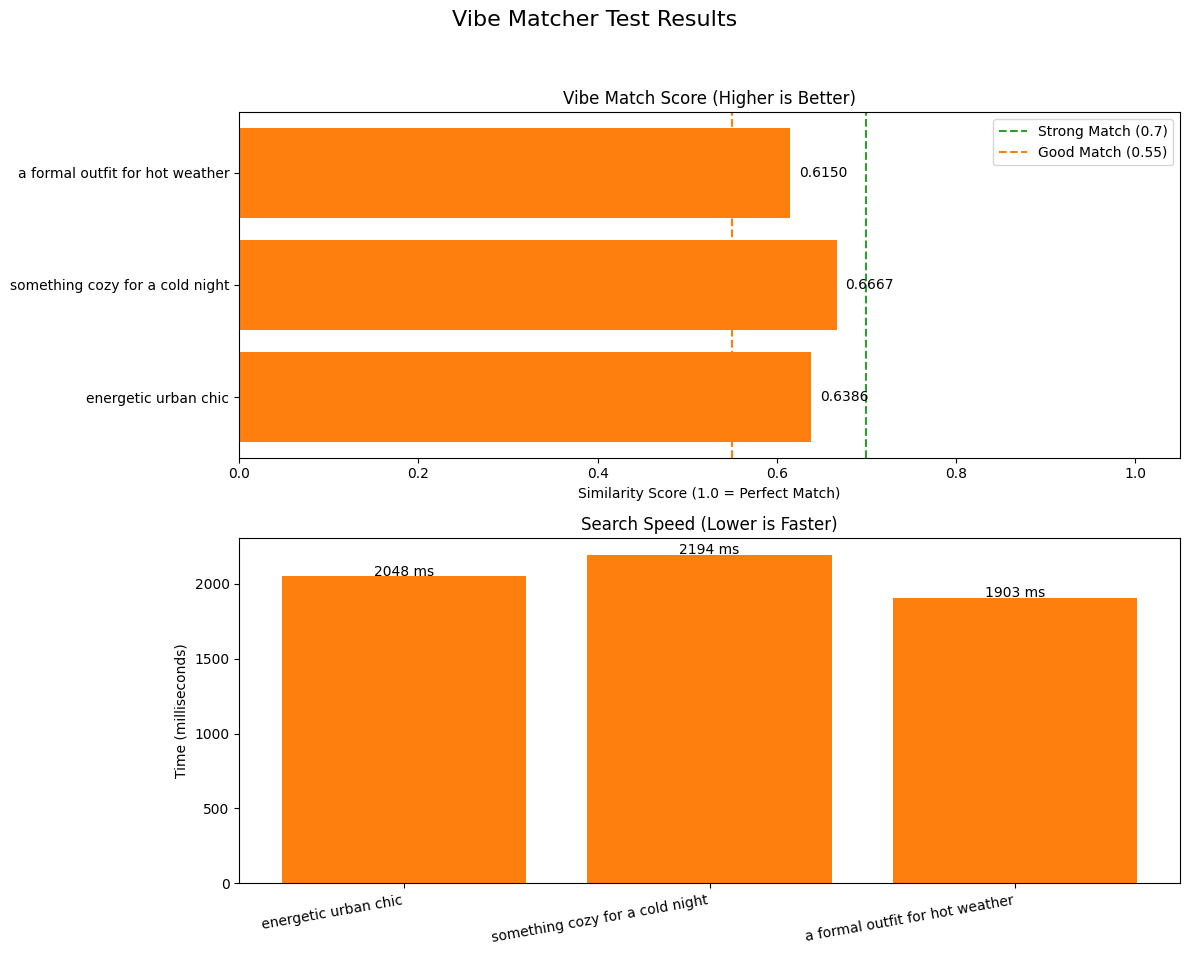

In [18]:
# --- Cell 6: Test & Evaluate ---

# Test queries
test_queries = [
    "energetic urban chic",
    "something cozy for a cold night",
    "a formal outfit for hot weather"
]

eval_log = []

# Thresholds for match quality
STRONG_THRESHOLD = 0.70  # Strong Match
GOOD_THRESHOLD = 0.55    # Good Match

# Color map for visualizations
color_map = {"Strong Match": "#2ca02c", "Good Match": "#ff7f0e", "No Match": "#d62728"}

print("--- 🧪 Starting Vibe Matcher Test & Evaluation ---")
print("Testing vibe queries and evaluating results.\n")
print("🔍 Match Quality Criteria:")
print(f"  - 🔥 Strong Match: Score >= {STRONG_THRESHOLD}")
print(f"  - 👍 Good Match:   Score >= {GOOD_THRESHOLD} and < {STRONG_THRESHOLD}")
print(f"  - ❌ No Match:     Score < {GOOD_THRESHOLD}")
print("-" * 50)

# Run tests
for i, query in enumerate(test_queries):
    print(f"\n--- Test Query {i+1}: '{query}' ---")

    # Measure latency
    start_time = timeit.default_timer()
    
    # Get top match score
    raw_query_embedding = get_gemini_embedding(query, task_type="RETRIEVAL_QUERY")
    normalized_query_embedding = normalize_vector(raw_query_embedding)
    
    top_score = 0.0
    match_quality = "No Match"
    
    if normalized_query_embedding:
        query_response = index.query(
            vector=normalized_query_embedding,
            top_k=1,
            include_metadata=False 
        )
        if query_response['matches']:
            top_score = query_response['matches'][0]['score']

    # Determine match quality
    if top_score >= STRONG_THRESHOLD:
        match_quality = "Strong Match"
    elif top_score >= GOOD_THRESHOLD:
        match_quality = "Good Match"
        
    # Get detailed results
    results_display = find_vibe_matches_pinecone(query, index, no_match_threshold=GOOD_THRESHOLD)
    
    end_time = timeit.default_timer()
    latency_ms = (end_time - start_time) * 1000
    
    # Log metrics
    log_entry = {
        "query": query,
        "top_score": top_score,
        "latency_ms": latency_ms,
        "match_quality": match_quality,
        "color": color_map[match_quality]
    }
    eval_log.append(log_entry)
    
    # Display results
    quality_emoji = {"Strong Match": "🔥", "Good Match": "👍", "No Match": "❌"}[match_quality]
    
    print(f"  📊 Match Score: {top_score:.4f}")
    print(f"  {quality_emoji} Match Quality: {match_quality}")
    print(f"  ⏱️ Search Speed: {latency_ms:.0f} ms ({latency_ms/1000:.2f} seconds)")
    
    print("\n  Top Results Found:")
    if isinstance(results_display, pd.DataFrame):
        for idx, row in results_display.iterrows():
            print(f"    {idx+1}. {row['name']} (Score: {row['similarity_score']:.4f})")
            print(f"       {row['desc'][:100]}...")
    else:
        print(f"    {results_display}")
    print("-" * 50)

# Display summary
eval_df = pd.DataFrame(eval_log)
print("\n\n--- 📈 Evaluation Metrics Summary ---")
eval_df_sorted = eval_df.sort_values(by="top_score", ascending=False)
print(eval_df_sorted.to_markdown(index=False, floatfmt=".4f"))

# Visualizations
print("\n\n--- 📊 Visual Results ---")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Vibe Matcher Test Results', fontsize=16)

# Plot 1: Match Scores
ax1.barh(eval_df['query'], eval_df['top_score'], color=eval_df['color'], align='center')
ax1.set_title('Vibe Match Score (Higher is Better)')
ax1.set_xlabel('Similarity Score (1.0 = Perfect Match)')
ax1.set_xlim(0, 1.05)

# Add threshold lines
ax1.axvline(STRONG_THRESHOLD, color=color_map["Strong Match"], linestyle='--', label=f'Strong Match ({STRONG_THRESHOLD})')
ax1.axvline(GOOD_THRESHOLD, color=color_map["Good Match"], linestyle='--', label=f'Good Match ({GOOD_THRESHOLD})')
ax1.legend()

# Add score labels
for i, (score, query) in enumerate(zip(eval_df['top_score'], eval_df['query'])):
    ax1.text(score + 0.01, i, f'{score:.4f}', va='center')

# Plot 2: Search Speed
ax2.bar(eval_df['query'], eval_df['latency_ms'], color=eval_df['color'])
ax2.set_title('Search Speed (Lower is Faster)')
ax2.set_ylabel('Time (milliseconds)')

# Add speed labels
for i, (speed, query) in enumerate(zip(eval_df['latency_ms'], eval_df['query'])):
    ax2.text(i, speed + 5, f'{speed:.0f} ms', ha='center')

plt.xticks(rotation=10, ha='right')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()